# Imports

In [1]:
from numpy import array, ndarray
from pandas import DataFrame, read_csv, concat, Series
from matplotlib.pyplot import savefig, show, figure, figure, savefig, show, subplots
from dslabs_functions import plot_multibar_chart, CLASS_EVAL_METRICS, run_NB, run_KNN, NR_STDEV, get_variable_types, determine_outlier_thresholds_for_var, plot_bar_chart
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# Método para avaliar dados

In [ ]:
def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "CLASS", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_NB != {} and eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_NB[met], eval_KNN[met]]
    return eval

In [39]:
def evaluate_knn(
    train: DataFrame, test: DataFrame, target: str = "CLASS", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_KNN[met]]
    return eval

# Load Financial Distress dataset

Variáveis escaladas para valores positivos

In [123]:
filename = "../data/class_financial_distress.csv"
file_tag = "financial_distress"
original_data: DataFrame = read_csv(filename, na_values="")
target = "CLASS"

# Shift all numeric features to be non-negative
numeric_features = original_data.select_dtypes(include=['float64', 'int64']).columns
original_data[numeric_features] = original_data[numeric_features] - original_data[numeric_features].min(axis=0)

labels: list = list(original_data[target].unique())
labels.sort()
print(f"Labels={labels}")

positive: int = 1
negative: int = 0
values: dict[str, list[int]] = {
    "Original": [
        len(original_data[original_data[target] == negative]),
        len(original_data[original_data[target] == positive]),
    ]
}

modified_filename = "datasets/class_financial_distress_encoded.csv"
original_data.to_csv(modified_filename, index=False)

Labels=[np.float64(0.0), np.float64(1.0)]


In [124]:
y: array = original_data.pop(target).to_list()
X: ndarray = original_data.values

# Split dados de Treino e de Teste

In [125]:
def split_dataset(X, y, file_tag, data):

    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

    train: DataFrame = concat(
        [DataFrame(trnX, columns=data.columns), DataFrame(trnY, columns=[target])], axis=1
    )
    train.to_csv(f"datasets/{file_tag}_train.csv", index=False)

    test: DataFrame = concat(
        [DataFrame(tstX, columns=data.columns), DataFrame(tstY, columns=[target])], axis=1
    )
    test.to_csv(f"datasets/{file_tag}_test.csv", index=False)

    values["Train"] = [
        len(train[train[target] == negative]),
        len(train[train[target] == positive]),
    ]
    values["Test"] = [
        len(test[test[target] == negative]),
        len(test[test[target] == positive]),
    ]

    # figure(figsize=(6, 4))
    # plot_multibar_chart(labels, values, title="Data distribution per dataset")
    # show()

In [126]:
split_dataset(X, y, file_tag, original_data)

# SCALING

# Standard Scaler

In [44]:
file = "financial_distress"
data: DataFrame = read_csv("../data/class_financial_distress.csv", na_values="")

target = "CLASS"
target_data: Series = data.pop(target)
vars: list[str] = data.columns.to_list()


transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(
    data
)
df_zscore = DataFrame(transf.transform(data))


df_zscore.columns = vars
df_zscore[target] = target_data

df_zscore.to_csv(f"datasets/{file}_scaled_zscore.csv", index=False)

Dados de treino e teste

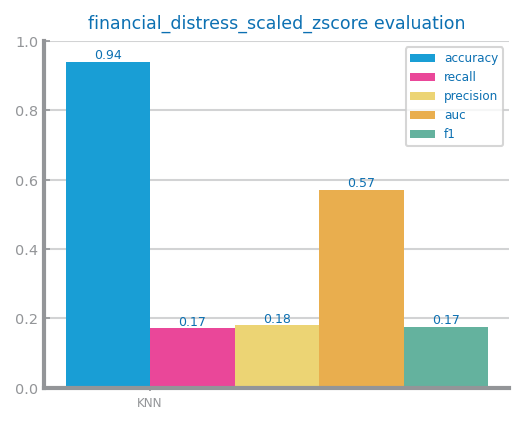

In [45]:
data: DataFrame = read_csv("datasets/financial_distress_scaled_zscore.csv", na_values="")
target = "CLASS"

# Shift all numeric features to be non-negative
# numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
# data[numeric_features] = data[numeric_features] - data[numeric_features].min(axis=0)

y: array = data.pop(target).to_list()
X: ndarray = data.values

file_tag = "financial_distress_scaled_zscore"

split_dataset(X, y, "financial_distress_scaled_zscore", data)

train: DataFrame = read_csv(f"datasets/{file_tag}_train.csv")
test: DataFrame = read_csv(f"datasets/{file_tag}_test.csv")

figure()
eval: dict[str, list] = evaluate_knn(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}_eval.png")
show()

# Min Max

In [46]:
file = "financial_distress"
data: DataFrame = read_csv("../data/class_financial_distress.csv", na_values="")
target = "CLASS"

target_data: Series = data.pop(target)
vars: list[str] = data.columns.to_list()


transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
df_minmax = DataFrame(transf.transform(data))
df_minmax.columns = vars
df_minmax[target] = target_data
df_minmax.to_csv(f"datasets/{file}_scaled_minmax.csv", index=False)

Dados de treino e teste

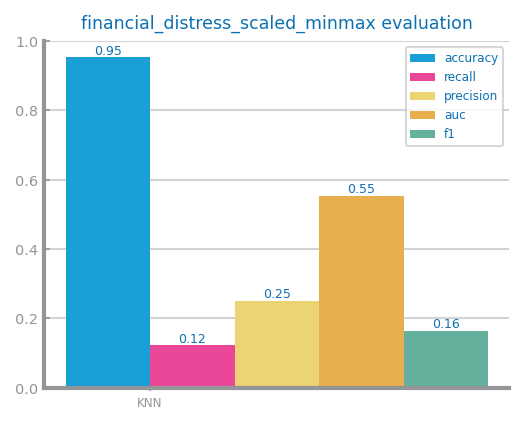

In [47]:
data: DataFrame = read_csv("datasets/financial_distress_scaled_minmax.csv", na_values="")

y: array = data.pop(target).to_list()
X: ndarray = data.values

file_tag = "financial_distress_scaled_minmax"

split_dataset(X, y, "financial_distress_scaled_minmax", data)

train: DataFrame = read_csv(f"datasets/{file_tag}_train.csv")
test: DataFrame = read_csv(f"datasets/{file_tag}_test.csv")

figure()
eval: dict[str, list] = evaluate_knn(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}_eval.png")
show()

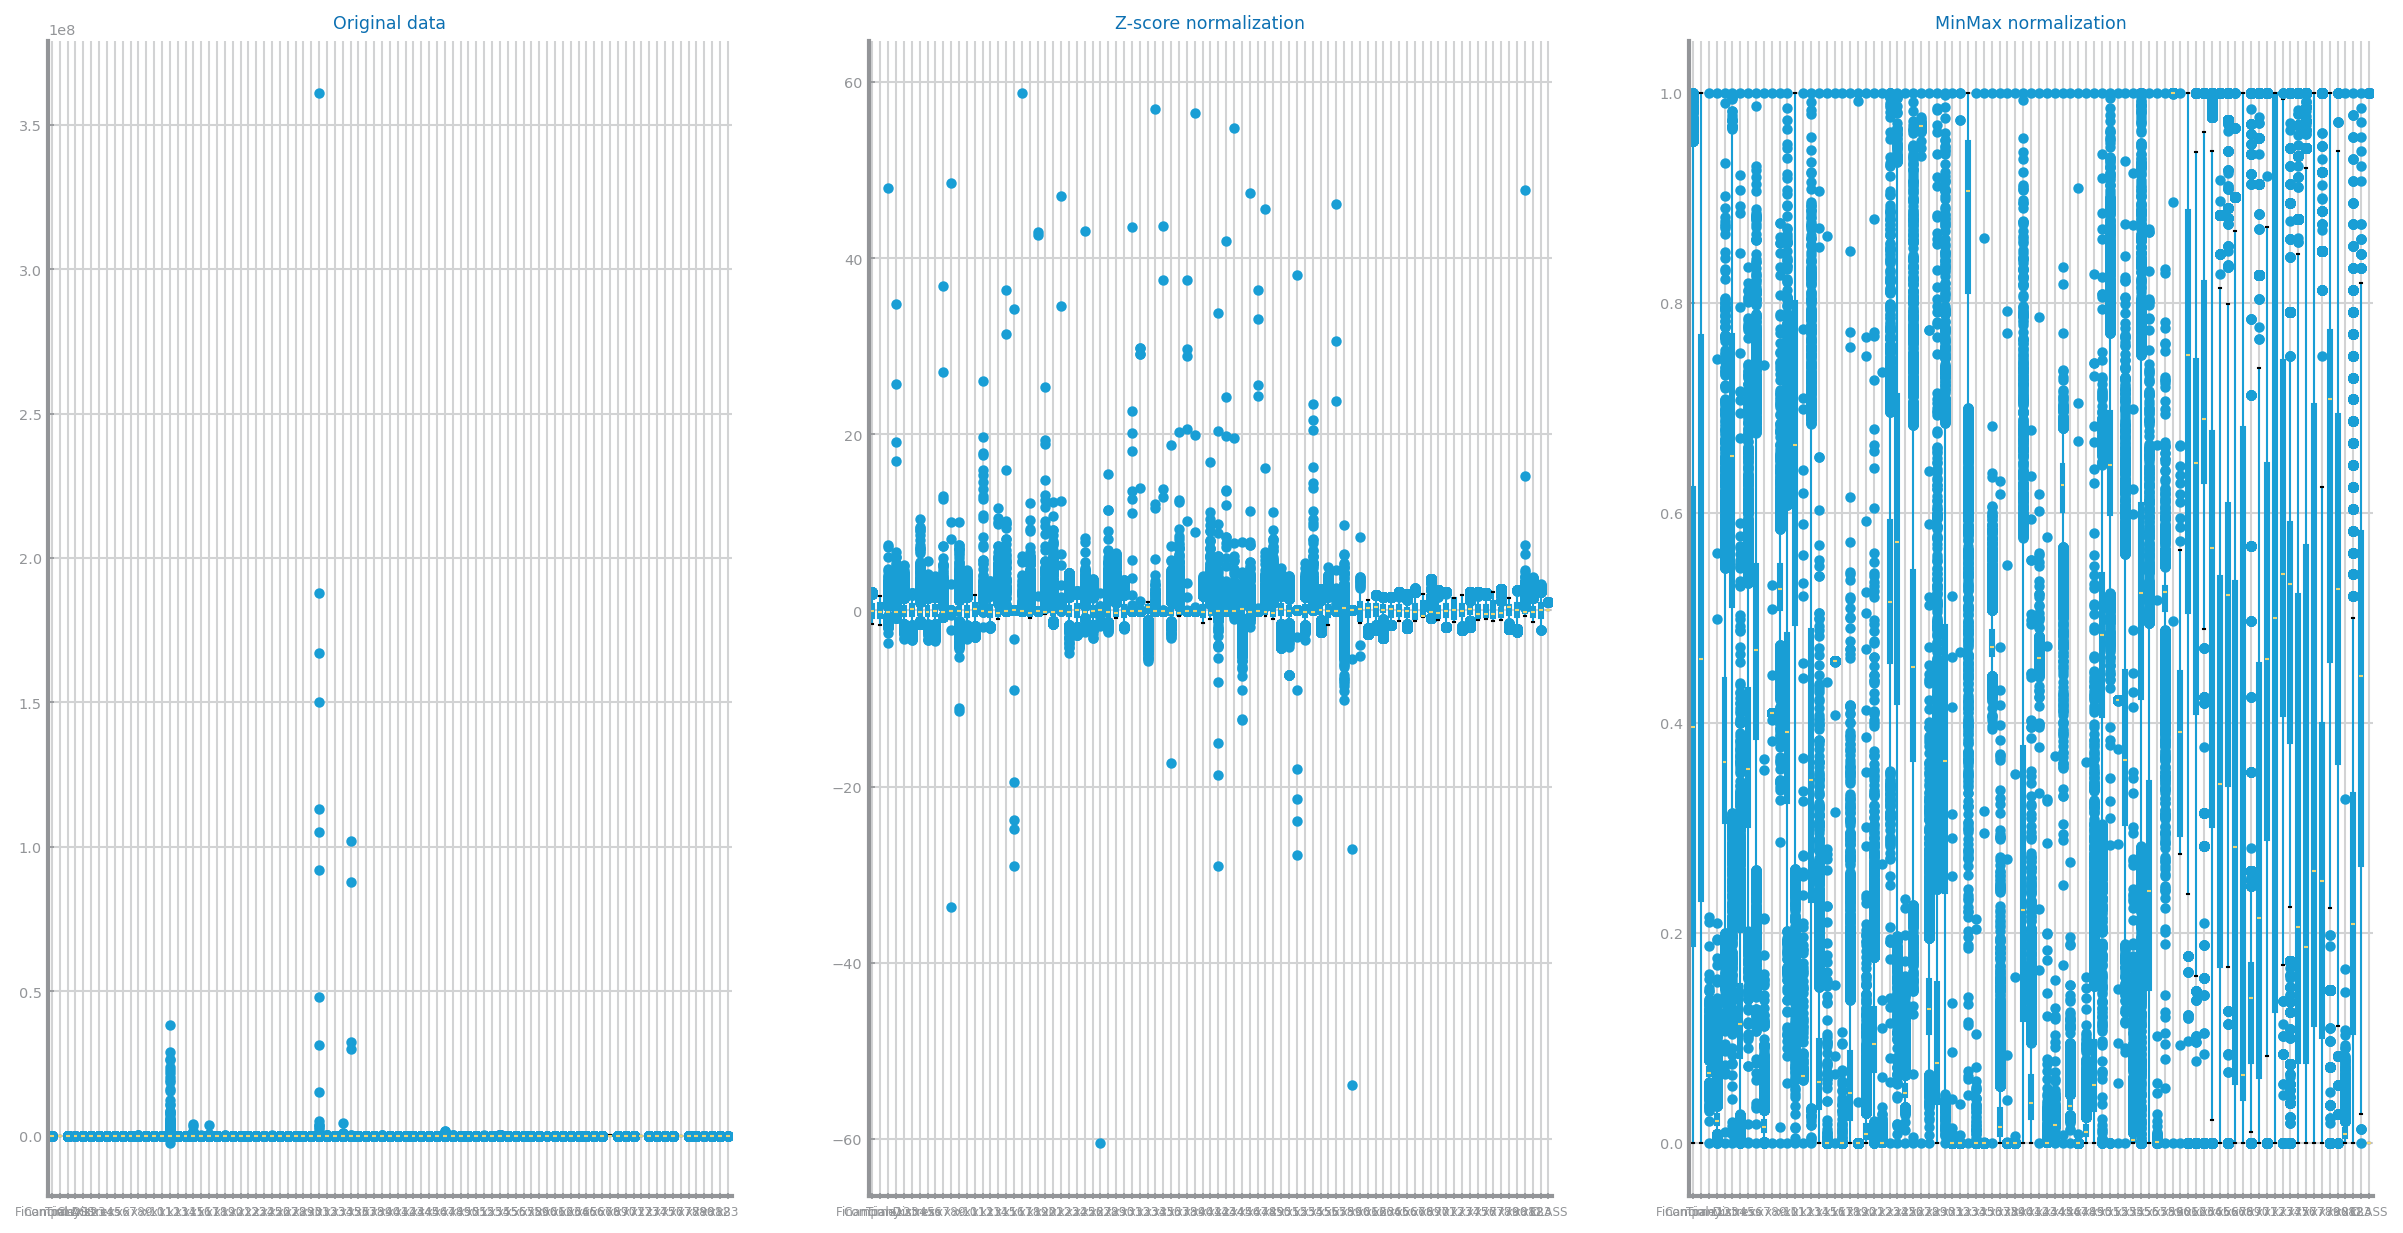

In [13]:
data: DataFrame = read_csv("../data/class_financial_distress.csv", na_values="")

fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
axs[0, 0].set_title("Original data")
data.boxplot(ax=axs[0, 0])
axs[0, 1].set_title("Z-score normalization")
df_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title("MinMax normalization")
df_minmax.boxplot(ax=axs[0, 2])
show()

# Balancing

# Undersampling

Minority class= 1.0 : 95
Majority class= 0.0 : 2475
Proportion: 0.04 : 1


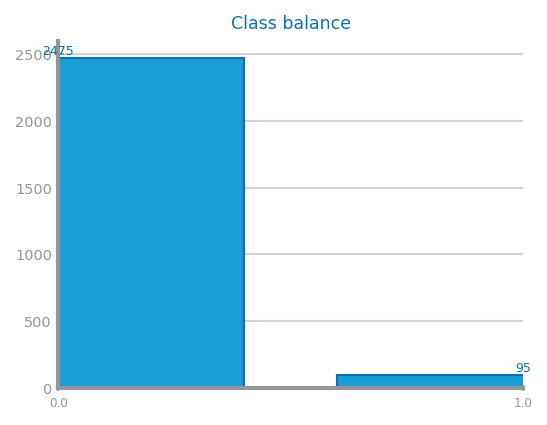

In [131]:
file_tag = "financial_distress"
target = "CLASS"
original: DataFrame = read_csv("datasets/financial_distress_train.csv", sep=",", decimal=".")

target_count: Series = original[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

Split into positive and negative datasets

In [132]:
df_positives: Series = original[original[target] == positive_class]
df_negatives: Series = original[original[target] == negative_class]

In [133]:
df_neg_sample: DataFrame = DataFrame(df_negatives.sample(len(df_positives)))
df_under: DataFrame = concat([df_positives, df_neg_sample], axis=0)
df_under.to_csv(f"datasets/financial_distress_train_under.csv", index=False)

print("Minority class=", positive_class, ":", len(df_positives))
print("Majority class=", negative_class, ":", len(df_neg_sample))
print("Proportion:", round(len(df_positives) / len(df_neg_sample), 2), ": 1")

Minority class= 1.0 : 95
Majority class= 0.0 : 95
Proportion: 1.0 : 1


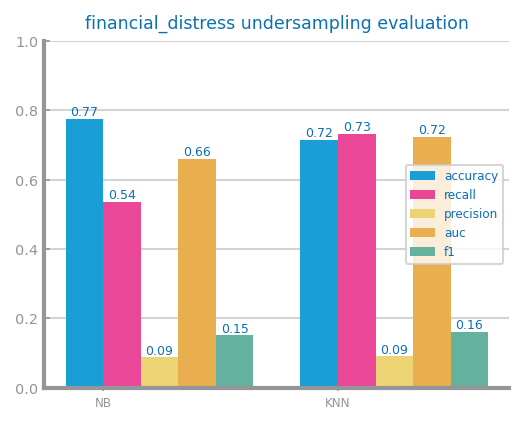

In [134]:
test: DataFrame = read_csv(f"datasets/financial_distress_test.csv")
train = df_under

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} undersampling evaluation", percentage=True
)
savefig(f"images/{file_tag}_undersampling_eval.png")
show()

# Oversampling

In [135]:
df_positives: Series = original[original[target] == positive_class]
df_negatives: Series = original[original[target] == negative_class]

In [136]:
df_pos_sample: DataFrame = DataFrame(
    df_positives.sample(len(df_negatives), replace=True)
)
df_over: DataFrame = concat([df_pos_sample, df_negatives], axis=0)
df_over.to_csv(f"datasets/financial_distress_train_over.csv", index=False)

print("Minority class=", positive_class, ":", len(df_pos_sample))
print("Majority class=", negative_class, ":", len(df_negatives))
print("Proportion:", round(len(df_pos_sample) / len(df_negatives), 2), ": 1")

Minority class= 1.0 : 2475
Majority class= 0.0 : 2475
Proportion: 1.0 : 1


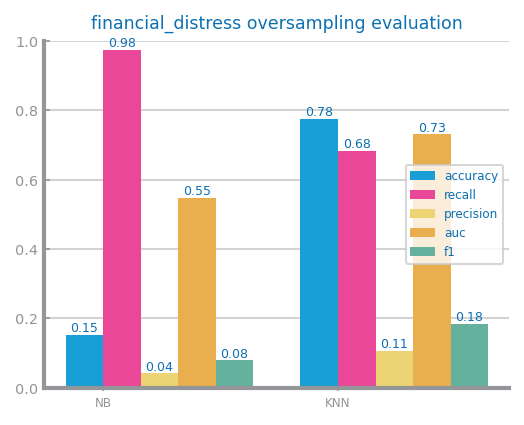

In [137]:
test: DataFrame = read_csv(f"datasets/financial_distress_test.csv")
train = df_over

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} oversampling evaluation", percentage=True
)
savefig(f"images/{file_tag}_oversampling_eval.png")
show()

# SMOTE

In [101]:
df_positives: Series = original[original[target] == positive_class]
df_negatives: Series = original[original[target] == negative_class]

In [102]:
RANDOM_STATE = 42

smote: SMOTE = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
y = original.pop(target).values
X: ndarray = original.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote: DataFrame = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(original.columns) + [target]
df_smote.to_csv(f"datasets/financial_distress_train_smote.csv", index=False)

smote_target_count: Series = Series(smote_y).value_counts()
print("Minority class=", positive_class, ":", smote_target_count[positive_class])
print("Majority class=", negative_class, ":", smote_target_count[negative_class])
print(
    "Proportion:",
    round(smote_target_count[positive_class] / smote_target_count[negative_class], 2),
    ": 1",
)
print(df_smote.shape)

Minority class= 1 : 2475
Majority class= 0 : 2475
Proportion: 1.0 : 1
(4950, 87)


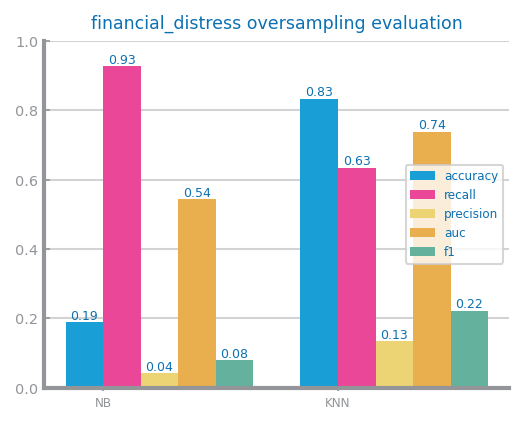

In [103]:
test: DataFrame = read_csv(f"datasets/financial_distress_test.csv")
train = df_smote

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} oversampling evaluation", percentage=True
)
savefig(f"images/financial_distress_smote_eval.png")
show()